In [1]:
import os
import sys
import glob
import numpy as np
import tables
from config import config
import nibabel as nib
import SimpleITK as sitk
from nilearn.image import reorder_img, resample_img, new_img_like
from nilearn import plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def fetch_training_data_files(category):
    training_data_files = list()
    for subject_dir in glob.glob(os.path.join(config["data_dir"], category, "*")):
        subject_files = list()
        for modality in config["training_modalities"]:
            subject_files.append(os.path.join(subject_dir, modality + ".nii.gz"))
        training_data_files.append(tuple(subject_files))
    return training_data_files

In [3]:
training_data_files = fetch_training_data_files("HGG")
example_files = training_data_files[:1]

In [9]:
example = nib.load(training_data_files[5][3])
example2 = sitk.ReadImage(training_data_files[1][1])

In [13]:
example2.GetSize()

(240, 240, 155)

In [5]:
def resize(image, new_shape, interpolation="continuous"):
    input_shape = np.asarray(image.shape, dtype=np.float16)
    ras_image = reorder_img(image, resample=interpolation)
    print(ras_image.affine)
    output_shape = np.asarray(new_shape)
    new_spacing = input_shape / output_shape
    print(new_spacing)
    new_affine = np.copy(ras_image.affine)
    new_affine[:3, :3] = ras_image.affine[:3, :3] * np.diag(new_spacing)
    return resample_img(ras_image, target_affine=new_affine, target_shape=output_shape, interpolation=interpolation)

resized = resize(example, config["image_shape"])

[[   1.    0.    0. -239.]
 [   0.    1.    0.    1.]
 [   0.    0.    1.    0.]
 [   0.    0.    0.    1.]]
[ 1.66666667  1.66666667  1.07638889]


/Users/namco/anaconda/envs/tensorflow/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


In [6]:
n = resized.get_data()
n.shape

(144, 144, 144)

In [99]:
def read_image_files(image_files, image_shape=None, crop=None):
    """

    :param image_files:
    :param image_shape:
    :param crop:
    :param use_nearest_for_last_file: If True, will use nearest neighbor interpolation for the last file. This is used
    because the last file may be the labels file. Using linear interpolation here would mess up the labels.
    :return:
    """
    image_list = list()
    for i, image_file in enumerate(image_files):
        image_list.append(resize(nib.load(image_file), image_shape))

    return np.stack([image.get_data() for image in image_list])


def create_data_file(image_files, out_file, nb_channels, nb_samples, image_shape):
    with tables.open_file(out_file, mode='w') as hdf5_file:
#         hdf5_file = tables.open_file(out_file, mode='w')
        filters = tables.Filters(complevel=5, complib='blosc')
        data_shape = tuple([0, nb_channels] + list(image_shape))
        data_storage = hdf5_file.create_earray(hdf5_file.root, 'data', tables.Float32Atom(), shape=data_shape,
                                           filters=filters, expectedrows=nb_samples)
        hdf5_file.create_array(hdf5_file.root, 'category', np.asarray([1]))
        for set_of_files in image_files:
            subject_data = read_image_files(set_of_files, image_shape)
            data_storage.append(subject_data[:nb_channels][np.newaxis])
            print(data_storage)
        return


def write_image_data_to_file(image_files, data_storage, image_shape, n_channels, crop=None):
    for set_of_files in image_files:
        subject_data = read_image_files(set_of_files, image_shape, crop=crop)
        data_storage.append(subject_data[:n_channels][np.newaxis])
    return data_storage


def write_data_to_file(training_data_files, out_file, image_shape):
    """
    Takes in a set of training images and writes those images to an hdf5 file.
    :param training_data_files: List of tuples containing the training data files. The modalities should be listed in
    the same order in each tuple. The last item in each tuple must be the labeled image. 
    Example: [('sub1-T1.nii.gz', 'sub1-T2.nii.gz', 'sub1-truth.nii.gz'), 
              ('sub2-T1.nii.gz', 'sub2-T2.nii.gz', 'sub2-truth.nii.gz')]
    :param out_file: Where the hdf5 file will be written to.
    :param image_shape: Shape of the images that will be saved to the hdf5 file.
    :param truth_dtype: Default is 8-bit unsigned integer. 
    :return: Location of the hdf5 file with the image data written to it. 
    """
    n_samples = len(training_data_files)
    n_channels = len(training_data_files[0])

    try:
        create_data_file(training_data_files, out_file, nb_channels=n_channels, 
                                                   nb_samples=n_samples, image_shape=image_shape)
    except Exception as e:
        # If something goes wrong, delete the incomplete data file
#         os.remove(out_file)
        raise e

#     crop_slices, affine, header = find_downsized_info(training_data_files, image_shape)
    
#     hdf5_file.create_array(hdf5_file.root, "affine", affine)
#     write_image_data_to_file(training_data_files, data_storage, image_shape, n_channels=n_channels)
#     normalize_data_storage(data_storage)
#     hdf5_file.close()
    return out_file


In [12]:
write_data_to_file(example_files, os.path.abspath("../data/data.hdf5"), config["image_shape"])

NameError: name 'write_data_to_file' is not defined

In [25]:
hdf5_file = tables.open_file("/Users/namco/Projects/3DUnetCNN/data/data.hdf5", mode='r')

In [6]:
a = hdf5_file.get_node(hdf5_file.root, 'data')
b = a.read().shape
# b[0][1].std()
# for i in range(4):
#     img = a.read()[0][i][70, :, :]
# #     print(img)
#     plt.figure(figsize=(30,30))
#     plt.subplot(5, 1, 1)
#     plt.imshow(img)
# # a = hdf5_file.get_node(hdf5_file.root, "category")
# # print(a[0])
b

(274, 4, 144, 144, 144)

In [31]:
data = hdf5_file.root.data.read()[0]
data.shape[0]

4

In [23]:
hdf5_file.close()

In [14]:
import numpy as np
from nilearn.image.image import check_niimg
from nilearn.image.image import _crop_img_to as crop_img_to


def crop_img(img, rtol=1e-8, copy=True, return_slices=False):
    """Crops img as much as possible
    Will crop img, removing as many zero entries as possible
    without touching non-zero entries. Will leave one voxel of
    zero padding around the obtained non-zero area in order to
    avoid sampling issues later on.
    Parameters
    ----------
    img: Niimg-like object
        See http://nilearn.github.io/manipulating_images/input_output.html
        img to be cropped.
    rtol: float
        relative tolerance (with respect to maximal absolute
        value of the image), under which values are considered
        negligeable and thus croppable.
    copy: boolean
        Specifies whether cropped data is copied or not.
    return_slices: boolean
        If True, the slices that define the cropped image will be returned.
    Returns
    -------
    cropped_img: image
        Cropped version of the input image
    """

    img = check_niimg(img)
    data = img.get_data()
    infinity_norm = max(-data.min(), data.max())
    passes_threshold = np.logical_or(data < -rtol * infinity_norm,
                                     data > rtol * infinity_norm)

    if data.ndim == 4:
        passes_threshold = np.any(passes_threshold, axis=-1)
    coords = np.array(np.where(passes_threshold))
    start = coords.min(axis=1)
    end = coords.max(axis=1) + 1

    # pad with one voxel to avoid resampling problems
    start = np.maximum(start - 1, 0)
    end = np.minimum(end + 1, data.shape[:3])

    slices = [slice(s, e) for s, e in zip(start, end)]

    if return_slices:
        return slices

    return crop_img_to(img, slices, copy=copy)


In [18]:
def read_image(in_file, image_shape=None, interpolation='continuous', crop=None):
    print("Reading: {0}".format(in_file))
    image = fix_shape(nib.load(in_file))
    if crop:
        image = crop_img_to(image, crop, copy=True)
    if image_shape:
        return resize(image, new_shape=image_shape, interpolation=interpolation)
    else:
        return image


def fix_shape(image):
    if image.shape[-1] == 1:
        return image.__class__(dataobj=np.squeeze(image.get_data()), affine=image.affine)
    return image


def resize(image, new_shape, interpolation="continuous"):
    input_shape = np.asarray(image.shape, dtype=np.float16)
    ras_image = reorder_img(image, resample=interpolation)
    output_shape = np.asarray(new_shape)
    new_spacing = input_shape / output_shape
    new_affine = np.copy(ras_image.affine)
    new_affine[:3, :3] = ras_image.affine[:3, :3] * np.diag(new_spacing)
    return resample_img(ras_image, target_affine=new_affine, target_shape=output_shape, interpolation=interpolation)


In [19]:
def find_downsized_info(training_data_files):
    foreground = get_complete_foreground(training_data_files)
    crop_slices = crop_img(foreground, return_slices=True, copy=True)
    cropped = crop_img_to(foreground, crop_slices, copy=True)
    # final_image = resize(cropped, new_shape=input_shape, interpolation="nearest")
    return crop_slices, cropped.affine, cropped.header


def get_complete_foreground(training_data_files):
    for i, set_of_files in enumerate(training_data_files):
        subject_foreground = get_foreground_from_set_of_files(set_of_files)
        if i == 0:
            foreground = subject_foreground
        else:
            foreground[subject_foreground > 0] = 1

    return new_img_like(read_image(training_data_files[0][-1]), foreground)


def get_foreground_from_set_of_files(set_of_files, background_value=0, tolerance=0.00001):
    for i, image_file in enumerate(set_of_files):
        image = read_image(image_file)
        is_foreground = np.logical_or(image.get_data() < (background_value - tolerance),
                                      image.get_data() > (background_value + tolerance))
        if i == 0:
            foreground = np.zeros(is_foreground.shape, dtype=np.uint8)

        foreground[is_foreground] = 1

    return foreground

In [25]:
slides, affine, header = find_downsized_info(training_data_files[:10])

Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0001_1/T1.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0001_1/T1c.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0001_1/Flair.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0001_1/T2.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0002_1/T1.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0002_1/T1c.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0002_1/Flair.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0002_1/T2.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0003_1/T1.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0003_1/T1c.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0003_1/Flair.nii.gz
Reading: /Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0003_1/T2.nii.gz
Reading: /Users/

In [31]:
image = fix_shape(example)
image = crop_img_to(image, slides, copy=True)

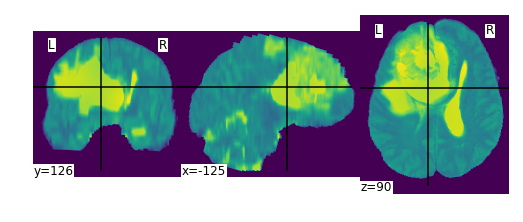

In [39]:
plotting.plot_img(image)

In [64]:
image_data = image.get_data()
image_data.shape

(150, 181, 148)

In [98]:
# Try to split the samples, but don't have sufficient information to classify subsamples
import math
for i in range(math.ceil(150/32)):
    for j in range(math.ceil(181/32)):
        for k in range(math.ceil(148/32)):
#             print(i, j, k)
            sub_image = image_data[32*i:32*(i+1), 32*j:32*(j+1), 32*k:32*(k+1)]
            for z, axis in enumerate(sub_image.shape):
                print(z, axis)
                if axis < 32:
                    p = np.lib.pad(sub_image[z], (3, 3), 'constant', constant_values=(0))
                    print(p)
                    print(p.shape)
#             print(sub_image.shape)
            
# image_data[32*4:32*5, 32*5:32*6, 32*4:32*5].shape

0 32
1 32
2 32
0 32
1 32
2 32
0 32
1 32
2 32
0 32
1 32
2 32
0 32
1 32
2 20
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

(38, 26)
0 32
1 21
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(27, 38)
2 32
0 32
1 21
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(27, 38)
2 32
0 32
1 21
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(27, 38)
2 32
0 32
1 21
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(27, 38)
2 32
0 32
1 21
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  

0 32
1 32
2 32
0 32
1 32
2 32
0 32
1 32
2 32
0 32
1 32
2 32
0 32
1 32
2 20
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

1 32
2 20
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0. ...,  0.  0.  0.]]
(27, 38)
1 21
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(27, 38)
2 32
0 22
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0. 

In [147]:
import pandas as pd
df = pd.read_csv(os.path.abspath("../data/data.csv"), header=None, usecols=[0])
# print(df)
df.values.reshape(df.size,).tolist()

['brats_2013_pat0001_1',
 'brats_2013_pat0002_1',
 'brats_2013_pat0004_1',
 'brats_2013_pat0006_1',
 'brats_2013_pat0008_1',
 'brats_2013_pat0011_1',
 'brats_2013_pat0012_1',
 'brats_2013_pat0013_1',
 'brats_2013_pat0014_1',
 'brats_2013_pat0015_1',
 'brats_tcia_pat101_0001',
 'brats_tcia_pat103_0001',
 'brats_tcia_pat109_0001',
 'brats_tcia_pat130_0001',
 'brats_tcia_pat141_0001',
 'brats_tcia_pat152_0001',
 'brats_tcia_pat175_0001',
 'brats_tcia_pat177_0001',
 'brats_tcia_pat202_0001',
 'brats_tcia_pat241_0001',
 'brats_tcia_pat249_0001',
 'brats_tcia_pat254_0001',
 'brats_tcia_pat255_0001',
 'brats_tcia_pat261_0001',
 'brats_tcia_pat266_0001',
 'brats_tcia_pat276_0001',
 'brats_tcia_pat282_0001',
 'brats_tcia_pat298_0001',
 'brats_tcia_pat299_0001',
 'brats_tcia_pat307_0001',
 'brats_tcia_pat312_0001',
 'brats_tcia_pat325_0001',
 'brats_tcia_pat330_0001',
 'brats_tcia_pat346_0001',
 'brats_tcia_pat351_0001',
 'brats_tcia_pat354_0001',
 'brats_tcia_pat387_0001',
 'brats_tcia_pat393_0

In [150]:
training_data_files = fetch_training_data_files("HGG")[:10]
training_data_files

[('/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0001_1/T1.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0001_1/T1c.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0001_1/Flair.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0001_1/T2.nii.gz'),
 ('/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0002_1/T1.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0002_1/T1c.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0002_1/Flair.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0002_1/T2.nii.gz'),
 ('/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0003_1/T1.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0003_1/T1c.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0003_1/Flair.nii.gz',
  '/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat0003_1/T2.nii.gz'),
 ('/Users/namco/Projects/3DUnetCNN/data/HGG/brats_2013_pat000